# Introduction

This Jupyter notebook is a light tutorial showing how to use some of the tools developed in our peer reviewed academic paper: [Vulnerability Forecasting: Theory and Practice](https://dl.acm.org/doi/pdf/10.1145/3492328) for those of you who like to read dusty academic papers. Our goal here is to drop the academic jargon, make the work reproducible, and let newcomers to forecasting make better forecasts than we ever could. That's you!

Before we begin that jouney of discovery, why should we even forecast? What can we do with such forecasts? Why are they useful?

1.   EASM and Vulnerability Management Planning
2.   Bridging the gap between risk and secops
3.   Board Level Cyber Risk Communication
4.   Software Supply Chain Dependency Prediction
5.   Cyber Insurance
6.   Equities Processes

Most people are focused on item one as part of the every day work of cybersecurity. Practicitioners dread out of cycle emergency patch releases, while managers wonder how big their teams should be. You are the core reason we started the Vuln4Cast project, and this tool is to help you plan for an uncertain future. You can now get rough answers to questions like "How many out of band patches might I reasonably expect in one month" or "What's the average CVSS score of a windows vulnerability?"

Setting a realistic vulnerability risk appetite is hard. You might say you want to have zero risk and patch everything, but you need to balance that against how much work that will be. These forecasts are reasonably accurate estimates to how much work that will be. In other words; at your yearly planning meeting you can ask *and answer* such questions as "if we patch everything above CVSS7 for Apache this year, how many vulnerabilities are we likely to handle?" or "If we take the risk of not patching this new product for two years in the field, how many of it's open source dependencies are likely to be network facing remote code execution or memory corruption?" 

Item three is important if you need to buy new tools to manage your assets and vulnerabilities, or you want to grow the team that uses them. Showing the growth rate of vulnerabilities that are within your defined risk appetite could mean the difference between getting the budget your team needs and another year of tehnical debt.

One of the things we *most* hope you will do is set a defined, quantified, risk appetite for patching.

The other items are a bit "big picture", so we won't waste your time here. The people doing those tasks will get it anyway, without our explanation. We'll help you demystify the CVE data, and start forecasting today!

# Setup our lab environment

First we'll import all the libraries we need. A couple of them need installed first. JQ is a pythonic implementation of jq; a tool for querying json. Hopefully some of you know it already. Hurst is a library that implements a forecasting metric called the Hurst exponent, which we will use later to demonstrate that CVEs have the right properties to be forecast at all.

In [1]:
!pip install requests
!pip install hurst
!pip install jq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import requests
import gzip as gz
import shutil
import pandas as pd
import json
import datetime
import tqdm
import os
import jq
import hurst
import json
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import numpy as np

In [3]:
# Increase size of plot in jupyter
plt.rcParams["figure.figsize"] = (20,12)

The folders where we will store the data as a gzip, and as a json need to be created.

In [4]:
file_exists = os.path.exists('CVE-NVD')
if not file_exists:
  os.mkdir('CVE-NVD')
  os.mkdir('CVE-NVD/GZIP')
  os.mkdir('CVE-NVD/JSON')

Let's also setup some other folders for MITRE's advance views of CVE data.

In [5]:
file_exists = os.path.exists('CVE-MITRE')
if not file_exists:
  os.mkdir('CVE-MITRE')
  os.mkdir('CVE-MITRE/CSV')

# Download the CVE data from NVD and MITRE

Now we'll download the NVD data for every year since 1999. Don't worry it's faster than you think.  
PROTIP: The progress bar comes for free from the tqdm package. Just wrap a for loop in tqdm.tqdm() it and you get a progress bar for free.
Now after this tutorial if you keep this notebook, you'll always be able to fetch all this CVE data easily. Handy for many more things than just forecasting.

In [6]:
now = datetime.datetime.now()
#PROTIP wrap an iterative loop in python with tqdm.tqdm() and you get a progress bar
for i in tqdm.tqdm(range(1999,now.year+1)):
    url = 'https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-'+str(i)+'.json.gz'
    req = requests.get(url, stream=True)
    with open('CVE-NVD/GZIP/nvdcve-1.1-'+str(i)+'.json.gz', 'wb') as f:
        for chunk in req.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                f.flush()

100%|██████████| 24/24 [00:59<00:00,  2.50s/it]


Here we need to decompress all those gzip files so we can work with the data as json files.

In [7]:
for i in tqdm.tqdm(range(1999,now.year+1)):
    with gz.open('CVE-NVD/GZIP/nvdcve-1.1-'+str(i)+'.json.gz', 'rb') as f_in:
        with open('CVE-NVD/JSON/nvdcve-1.1-'+str(i)+'.json', 'wb')  as f_out:
            shutil.copyfileobj(f_in, f_out)

100%|██████████| 24/24 [00:04<00:00,  4.89it/s]


Now we need to download the MITRE version of CVEs too, which gives us a different kind of information that is useful later. Specifically, it gives us a view of CVEs that didn't make the cut, and some other timestamps we can use to show when CVEs where submitted, as opposed to published. That can help us calculate the rate of publication.

In [8]:
url = 'https://cve.mitre.org/data/downloads/allitems.csv'
req = requests.get(url, stream=True)
now = datetime.datetime.now()
with open('CVE-MITRE/CSV/allitems_current.csv', 'wb') as f:
    for chunk in req.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)
            f.flush()

# Convert the data to panda dataframes and csv files

Here we start to use JQ to make queiries specific to CVE json structure. We pull out the CVE-ID, the published date, the assigner, and the CVSSv2 base score.

In [9]:
cve_id_query = jq.compile(".CVE_Items[].cve.CVE_data_meta.ID")
cve_publication_query = jq.compile(".CVE_Items[].publishedDate")
cve_assigner_query = jq.compile(".CVE_Items[].cve.CVE_data_meta.ASSIGNER")
cvss_score_query = jq.compile(".CVE_Items[].impact.baseMetricV2.cvssV2.baseScore")
now = datetime.datetime.now()
collector = []
for i in tqdm.tqdm(range(2002, now.year+1)):
    with open('CVE-NVD/JSON/nvdcve-1.1-'+str(i)+'.json') as json_file:
        data = json.load(json_file)
        pubs = cve_publication_query.input(data).text()
        pubs = pubs.split('\n')
        pubs = [pd.to_datetime(ts.strip('"'), yearfirst=True, infer_datetime_format=True) for ts in pubs]
        index= pd.Series(pubs,name='Publication')
        cves = cve_id_query.input(data).text()
        cves = cves.split('\n')
        cves = [cve.strip('"') for cve in cves]
        assigners = cve_assigner_query.input(data).text()
        assigners = assigners.split('\n')
        cvss = cvss_score_query.input(data).text()
        cvss = cvss.split('\n')
        #print(cvss)
        s1 = pd.Series(cves,name='ID')
        s2 = pd.Series(assigners,name='ASSIGNER')
        ones = [1]*len(cves)
        s3 = pd.Series(ones,name='Count')
        s4 = pd.Series(cvss,name='CVSS')
        vulns = pd.concat([index,s1,s2,s3,s4], axis=1)
        vulns = vulns.set_index('Publication')
        collector.append(vulns)
        json_file.close()
all_items = pd.concat(collector)

100%|██████████| 21/21 [06:12<00:00, 17.73s/it]


Save all the data we just filtered to a CSV file, for future use.

In [10]:
all_items.sort_index()
all_items.to_csv('NVD-Vulnerability-Volumes.csv')

If you want to read that file in the future, just uncoment the cell below.

In [11]:
#all_items = pd.read_csv('NVD-Vulnerability-Volumes.csv',parse_dates=['Publication'],infer_datetime_format=True)
#all_items.set_index('Publication')

# How do we even know forecasting CVEs is possible?

We will use the [Generlised Hurst Exponent](https://pubsonline.informs.org/do/10.1287/LYTX.2012.04.05/full/)! 

"Put simply, the Hurst exponent is used as a measure of the long-term memory of a time series."

It categorises a timeseries into 1 of three categories: truly random (H=0.5), mean reverting (H<0.5), or long term trending (H>0.5). As we can see in the experiment below, H is about 0.85, reflecting a series that is showing strong trending. This let's us conclude two important thing:



1.   This is forecastable, because it has long term trend.
2.   This should not be forecast with averages!

So regardless of which model we build for forecasting, we know it is possible before we start.

In [12]:
# compute_Hc returns a tuple of 3 values 
H, c, data = hurst.compute_Hc(all_items['Count'].resample('D').sum(), kind='change', simplified=True)

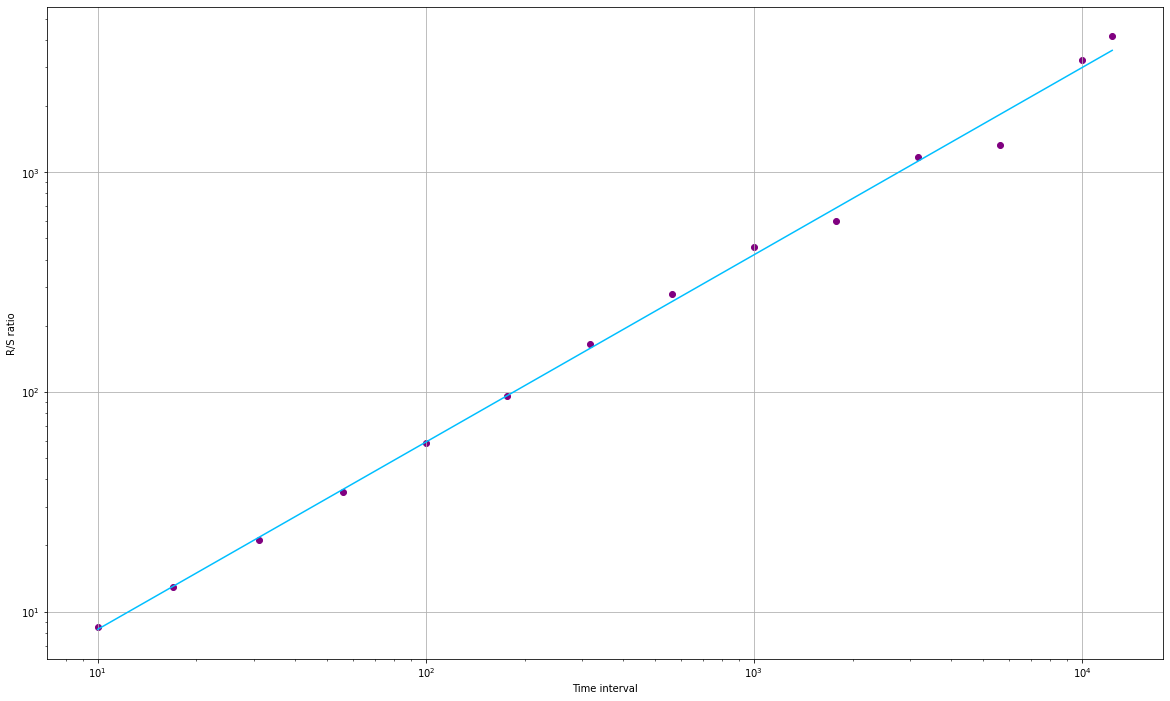

In [13]:
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

In [14]:
print("H={:.4f}, c={:.4f}".format(H,c))

H=0.8523, c=1.1662


Below we can see a visualisation of how many vulnerabilities come out weekly. This is also useful because it let's us discuss why weekly averages wouldn't be useful for a forecast, or more specifically, would have so much variance we wouldn't have much confidence.

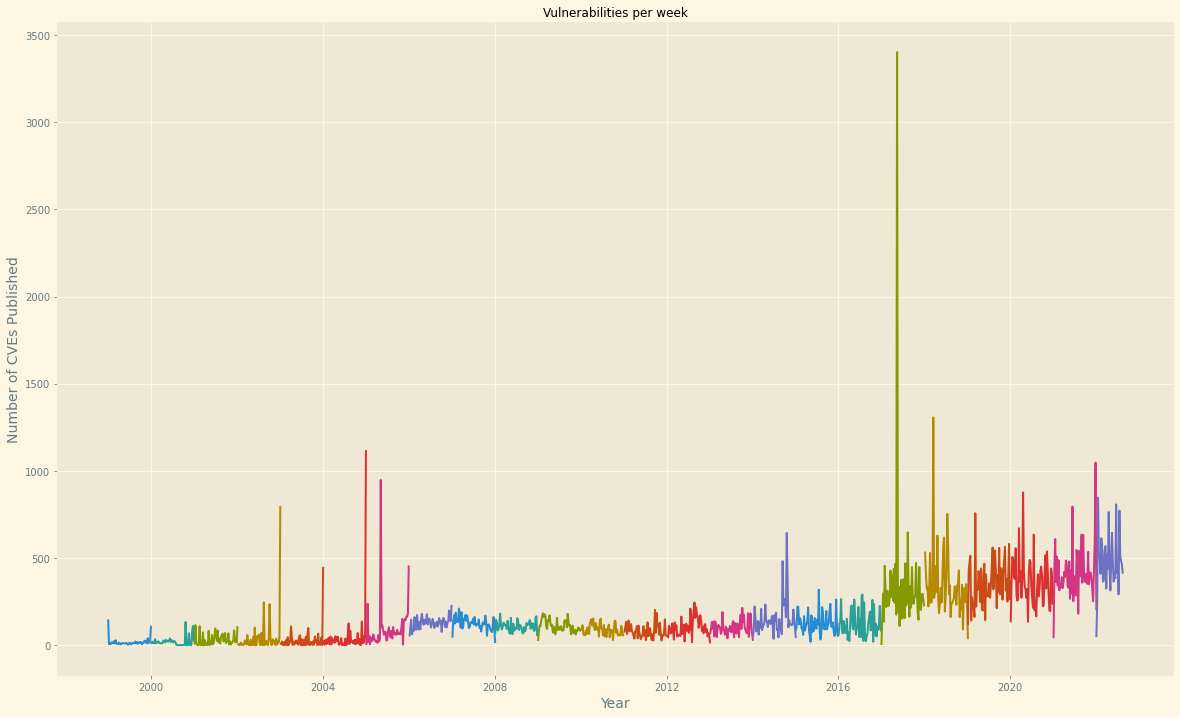

In [15]:
now = datetime.datetime.now()
all_years = []
with plt.style.context('Solarize_Light2'):
    for i in range(1999, now.year+1):
        yearly_plot = all_items['Count'][all_items.index.year==i]
        yearly_plot = yearly_plot.sort_index()
        all_years.append(yearly_plot)
        plt.plot(yearly_plot.resample('W').sum().index,yearly_plot.resample('W').sum())
    
# Number of accent colors in the color scheme
plt.title('Vulnerabilities per week')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of CVEs Published', fontsize=14)

plt.show()

# What proportion of CVEs have specific CVSS scores?

In [16]:
all_items = all_items.sort_index()
all_data=all_items['Count']
drop_null = all_items[all_items.CVSS != 'null']
data_above_2 = drop_null[drop_null['CVSS'].astype(float)>2.0]['Count']
data_above_3 = drop_null[drop_null['CVSS'].astype(float)>3.0]['Count']
data_above_4 = drop_null[drop_null['CVSS'].astype(float)>4.0]['Count']
data_above_5 = drop_null[drop_null['CVSS'].astype(float)>5.0]['Count']
data_above_6 = drop_null[drop_null['CVSS'].astype(float)>6.0]['Count']
data_above_7 = drop_null[drop_null['CVSS'].astype(float)>7.0]['Count']
data_above_8 = drop_null[drop_null['CVSS'].astype(float)>8.0]['Count']
data_above_9 = drop_null[drop_null['CVSS'].astype(float)>9.0]['Count']
data_above_2 = data_above_2.resample('M').sum()
data_above_3 = data_above_3.resample('M').sum()
data_above_4 = data_above_4.resample('M').sum()
data_above_5 = data_above_5.resample('M').sum()
data_above_6 = data_above_6.resample('M').sum()
data_above_7 = data_above_7.resample('M').sum()
data_above_8 = data_above_8.resample('M').sum()
data_above_9 = data_above_9.resample('M').sum()
all_data = all_data.resample('M').sum()
cve_counts = pd.concat([all_data,data_above_2,data_above_3,data_above_4,data_above_5,data_above_6,data_above_7,data_above_8,data_above_9], axis=1)

In [17]:
cve_counts.columns.values[0] = 'Total CVE Count'
cve_counts.columns.values[1] = 'CVSS Above 2'
cve_counts.columns.values[2] = 'CVSS Above 3'
cve_counts.columns.values[3] = 'CVSS Above 4'
cve_counts.columns.values[4] = 'CVSS Above 5'
cve_counts.columns.values[5] = 'CVSS Above 6'
cve_counts.columns.values[6] = 'CVSS Above 7'
cve_counts.columns.values[7] = 'CVSS Above 8'
cve_counts.columns.values[8] = 'CVSS Above 9'
cve_counts.to_csv('CVSSProportion.csv')

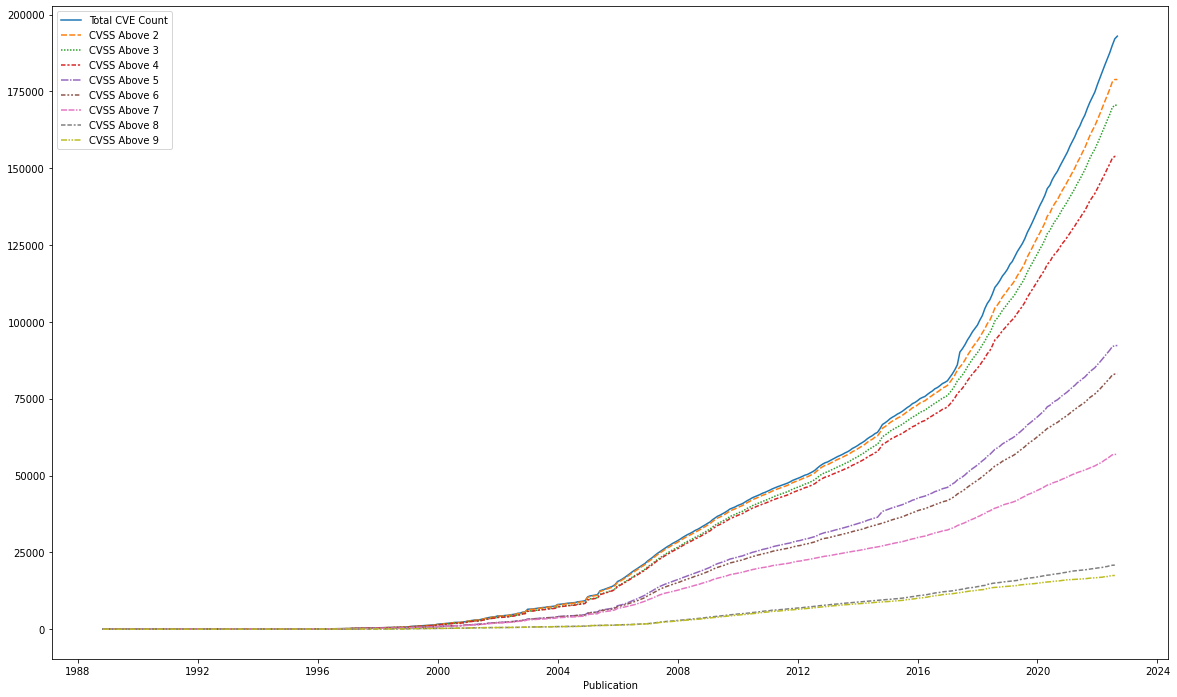

In [18]:
#Graph the proportions of vulnerabilities by CVSS score
ax = sns.lineplot(data=cve_counts.cumsum())
plt.show()

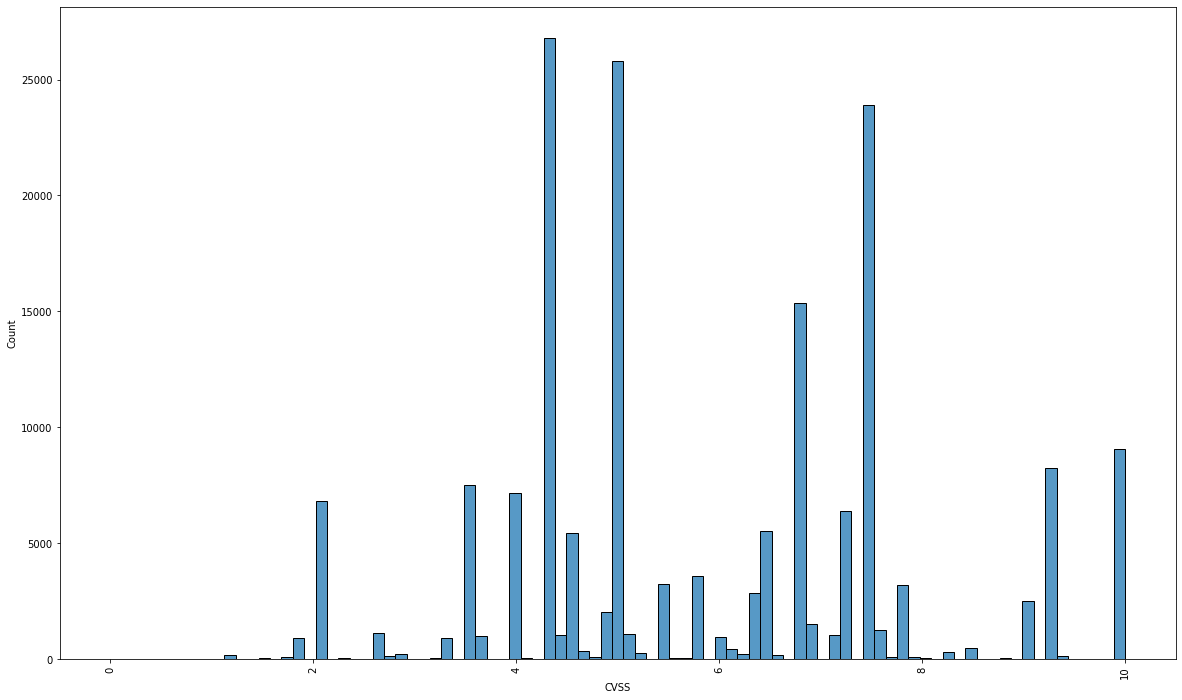

In [19]:
ax = sns.histplot(drop_null['CVSS'].astype(float).sort_values())
ax.tick_params(axis='x', rotation=90)

##Exercise 1: Warm up by checking some data

Check that the CVSS score percentages sum to one.

In [20]:
#Let's a table of CVSS score percentages so we can use it later
df = drop_null['CVSS'].astype(float).value_counts() / len(drop_null['CVSS'])
df.sort_index()
#TODO check they sum to 1

0.0     0.000128
1.0     0.000050
1.2     0.000961
1.3     0.000011
1.4     0.000022
          ...   
9.0     0.013953
9.3     0.045819
9.4     0.000683
9.7     0.000061
10.0    0.050389
Name: CVSS, Length: 73, dtype: float64

For an exceptional (and lengthy) deep dive on CVSS scores and their distribution and methodology see [Theory Of Predictiable Software](https://theoryof.predictable.software/articles/a-closer-look-at-cvss-scores/).

# Forecasting with CVE-IDs

To construct a serial number prediction forecasting model, we need to divide all the CVEs that have a string format containing this year. This will be "observations" of how many vulnerabilities have we already observed of the form CVE-2022-XXXXXX. This will allow us to estimate the size of the queue of vulnerabilities at NVD waiting for confirmation. 

CVE-YEAR-XXXX[XX]
CVE = Common Vulnerability Enumeration
YEAR = Year of ASSIGNMENT (NOT YEAR OF PUBLICATION)
XXXX = Sequential numbers across all CVEs

##Exercise 2: Find CVEs published in different years than their ID Shows
Find some CVEs that have a different year of publication, than year in their ID.
##Bonus points for finding the CVE that took the longest time to get published.

In [21]:
#Prove to yourself that the year reflects the date of assignment NOT the date of publication. Find a CVE that is published in a different year than it's ID
all_items.head(10)
#BONUS - What CVE took the most years to be published?

,ID,ASSIGNER,Count,CVSS
Publication,,,,
1988-10-01 04:00:00,CVE-1999-0095,"""cve@mitre.org""",1,10
1988-11-11 05:00:00,CVE-1999-0082,"""cve@mitre.org""",1,10
1989-01-01 05:00:00,CVE-1999-1471,"""cve@mitre.org""",1,7.2
1989-07-26 04:00:00,CVE-1999-1122,"""cve@mitre.org""",1,4.6
1989-10-26 04:00:00,CVE-1999-1467,"""cve@mitre.org""",1,10
1990-01-29 05:00:00,CVE-1999-1506,"""cve@mitre.org""",1,7.5
1990-05-01 04:00:00,CVE-1999-0084,"""cve@mitre.org""",1,7.2
1990-05-09 04:00:00,CVE-2000-0388,"""cve@mitre.org""",1,7.5
1990-08-14 04:00:00,CVE-1999-0209,"""cve@mitre.org""",1,5


[In WWII Britain estimated German Mark IV and V tank production numbers from the serial numbers on their transmission systems.](https://www.theguardian.com/world/2006/jul/20/secondworldwar.tvandradio). This serial number as a predictor of population size is taught in various statistics classes. We're going to do the exact same thing with CVE ids. That will show us the number of CVEs waiting in reserve

First we'll need to get data in the right format to use for a serial number predictor.

In [22]:
#Takes a datetime.datetime() object
#For example, if we want to predict from Juneteenth 2018 at 1 AM:
#datetime.datetime(2018, 6, 19, 1, 0) 
def getiddata(date_of_prediction):
  #We make this date global so we can access it later for retrocasting
  #For example we would need to add a year to it and check the actuals
  global prediction
  prediction = date_of_prediction
  year = date_of_prediction.year
  #date = pd.to_datetime(filter_date, format='%Y%m%d %H%M')
  # all_items = all_items[all_items.index<=date]
  df = all_items[all_items.index<=date_of_prediction]
  ids = df['ID'].to_list()
  this_year = []
  for i in ids:
    triple = i.split('-')
    if triple[1] == str(year):
      this_year.append(triple[2])
  return this_year

In [23]:
#this_year = getiddata(datetime.datetime(2018, 6, 19, 1, 0))
this_year = getiddata(now)

We also need to use this number of observations to increase our confidence as we see more observations. To put it simply, when we've only seen a handful of vulnerabilities come out, we're not very confident of our forecast, but after thousands it's much more accurate. This number of observations helps us scale our confidence.

In [24]:
#Observations of CVE IDs matching the pattern with the year of interest.
obs = len(this_year)
obs

10833

The number below captures the number of CVEs that have been published this year, but also includes those that were assigned and logged in previous years (I.E. Have a different CVE-ID Year).That's why it is larger, and more accurately reflects the number that have *come out this year* than the observations variable above.

In [25]:
#Different but related question, how many vulnerabilities have come out this year?
#NOTE we used the global variable prediction here to make retrocasting easier leter on
mask = (all_items.index >= datetime.datetime(prediction.year,1,1,0)) & (all_items.index <= prediction)
this_year_count = len(all_items.loc[mask])
this_year_count

15776

Now we can subtract one from the other to see how many vulnerabilities published this year were assigned in earlier years.

In [26]:
lagged_publications = this_year_count-obs
lagged_publications

4943

Here we finally construct our first forecast, the basic serial number prediction or "minimum variance unbiased estimator" (MVUE for short) discussed in the history article. We scale it's projections by the number of observations. For those of you who are mathematicallty minded, this is really a simple equation:

$N \approx MAXID + \frac{MAXID}{OBSERVATIONS} - 1$

Note how the fraction converges towards one as you witness all CVE IDs, and the -1 at the end cancels this out. This scaling factor helps us scale a lot when we have a small number of samples at the beggining of the year, and then a very small amount when we have more observations toward the end of the year. In other words, we get more accurate the more CVEs are released.

Now don't forget this number predicts how many vulnerabilities there are with a specific format, not exactly how many will be published. In short it estimates the size of the queue waiting to be published. So we need to scale this number down by the number that will be not be published within the year. Which is roughly 5%.

In [27]:
#Queue size
mvue = round(int(max(this_year))+(int(max(this_year))/int(obs))-1)
mvue = mvue*0.95

##Exercise 3: Add prediction intervals

Here we're going to teach you the most naive way to calculate prediction intervals, because you can use it in almost any situation. Later, we'll show you a better way.

If you have a sequence of $N$ numbers, and you add one more...the chance of it being larger than any of the others is $\frac{1}{N+1}$. Similarly, the chance of it being smaller than any of other numbers is the same. Thus the chance of it being between all the other numbers in the sequence is the reciprocal $\frac{N-2}{N}$. This is obviously untrue when you know the distribution of the numbers, but is a way to estimate when you have NO OTHER INFORMATION AVAILABLE.

Much better ways are to test your error rates empirically. This can take a long time, if you make a prediction, and then wait to find out if it was accurate. 

In [28]:
naive_prediction_interval = round(obs-2/obs)
naive_prediction_interval

10833

In [29]:
naive_upper_prediction_interval = round(mvue*0.95+naive_prediction_interval)
naive_upper_prediction_interval

45276

In [30]:
naive_lower_prediction_interval = round(mvue*0.95-naive_prediction_interval)
naive_lower_prediction_interval

23610

Now, we'll need some way of measuring the quality of forecasts which has a lovely side effect of narrowing our prediction intervals to a much more useful level. Ideally, you retrocast or back test every value you could have historically, and test your error rates. We may not have time or computing power to do all that today, so we'll use the value in our paper which was the average MAPE over all years we studied.

In [31]:
#We'll use the empirical values Matilda and I discovered in the paper because testing them again could take you weeks!
average_mape = 0.08
empirical_prediction_interval = average_mape*mvue
#HOMEWORK write a method to retrocast/backtest predictions against historical data using MAE and MAPE functions below

In [32]:
#Mean Absolute Error
def mae(Y_actual, Y_Predicted):
    return np.mean(np.abs(Y_actual - Y_Predicted))

#Mean Absolute Percentage Error
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [33]:
mape_lower_prediction_interval = round(mvue-empirical_prediction_interval)
mape_lower_prediction_interval

33355

In [34]:
mape_upper_prediction_interval = round(mvue+empirical_prediction_interval)
mape_upper_prediction_interval

39156

In [39]:
#TODO Graph actual counts, and the prediction and the prediction intervals as projections
df = all_items[all_items.index<=prediction]
#sns.lineplot(df['Count'].cumsum())
df['Count'].cumsum()

Publication
1988-10-01 04:00:00         1
1988-11-11 05:00:00         2
1989-01-01 05:00:00         3
1989-07-26 04:00:00         4
1989-10-26 04:00:00         5
                        ...  
2022-08-11 15:15:00    192993
2022-08-11 15:15:00    192994
2022-08-11 15:15:00    192995
2022-08-11 15:15:00    192996
2022-08-11 15:15:00    192997
Name: Count, Length: 192997, dtype: int64

In [42]:
file = 'CVE-MITRE/CSV/allitems_current.csv'
mitre_view = pd.read_csv(file, encoding='latin1',skiprows=[0,1,3,4,5,6,7,8,9],low_memory=False)

In [43]:
operations_df = mitre_view['Phase'].str.split(' ',expand=True)
mitre_view['Operation'] = operations_df[0]
mitre_view['Operation Date'] = operations_df[1].str.replace('(','').str.replace(')','')
mitre_view['Operation Date'] = pd.to_datetime(mitre_view['Operation Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


##Exercise 4: What is the average service time?

Another way to look at average service time, is to ask what is the probability that a CVE that is assigned is published within a certain window.

In [62]:
mitre_view['Operation Date'] = pd.to_datetime(mitre_view['Operation Date'])
mitre_view = mitre_view.rename(columns={'Name': 'ID'})
merged_data = pd.merge(all_items.reset_index(), mitre_view, how='left', on="ID")
merged_data = merged_data.set_index('Publication')
#Compare these mitre assignment dates against publication dates in the nvd data
merged_data[merged_data['Operation']=='Assigned'].head(10)

,ID,ASSIGNER,Count,CVSS,Status,Description,References,Phase,Votes,Comments,Operation,Operation Date
Publication,,,,,,,,,,,,
1995-08-23 04:00:00,CVE-1999-1580,"""cve@mitre.org""",1,7.2,Candidate,SunOS sendmail 5.59 through 5.65 uses popen to...,AUSCERT:AA-95.09 | URL:http://www.auscert....,Assigned (20050421),None (candidate not yet proposed),NaN,Assigned,2005-04-21
1996-07-16 04:00:00,CVE-1999-1572,"""cve@mitre.org""",1,2.1,Candidate,"cpio on FreeBSD 2.1.0, Debian GNU/Linux 3.0, a...",BUGTRAQ:20050204 [USN-75-1] cpio vulnerability...,Assigned (20050127),None (candidate not yet proposed),NaN,Assigned,2005-01-27
1997-12-23 05:00:00,CVE-1999-1581,"""cve@mitre.org""",1,5,Candidate,Memory leak in Simple Network Management Proto...,CERT-VN:VU#4923 | URL:http://www.kb.cert.o...,Assigned (20050421),None (candidate not yet proposed),NaN,Assigned,2005-04-21
1998-07-06 04:00:00,CVE-1999-1574,"""cve@mitre.org""",1,7.5,Candidate,Buffer overflow in the lex routines of nslooku...,AIXAPAR:IX79909 | URL:http://www-1.ibm.com...,Assigned (20050421),None (candidate not yet proposed),NaN,Assigned,2005-04-21
1998-07-15 04:00:00,CVE-1999-1582,"""cve@mitre.org""",1,7.5,Candidate,"By design, the ""established"" command on the Ci...",CERT-VN:VU#6733 | URL:http://www.kb.cert.o...,Assigned (20050421),None (candidate not yet proposed),NaN,Assigned,2005-04-21
1999-09-10 04:00:00,CVE-1999-1575,"""cve@mitre.org""",1,5.1,Candidate,"The Kodak/Wang (1) Image Edit (imgedit.ocx), (...",BUGTRAQ:19990924 Several ActiveX Buffer Overru...,Assigned (20050421),None (candidate not yet proposed),NaN,Assigned,2005-04-21
1999-09-24 04:00:00,CVE-1999-1578,"""cve@mitre.org""",1,5.1,Candidate,Buffer overflow in Registration Wizard ActiveX...,BID:671 | URL:http://www.securityfocus.com...,Assigned (20050421),None (candidate not yet proposed),NaN,Assigned,2005-04-21
1999-09-27 04:00:00,CVE-1999-1576,"""cve@mitre.org""",1,7.5,Candidate,Buffer overflow in Adobe Acrobat ActiveX contr...,BID:666 | URL:http://www.securityfocus.com...,Assigned (20050421),None (candidate not yet proposed),NaN,Assigned,2005-04-21
1999-09-30 04:00:00,CVE-1999-1583,"""cve@mitre.org""",1,7.2,Candidate,Buffer overflow in nslookup for AIX 4.3 allows...,AIXAPAR:IY02120 | URL:http://www-1.ibm.com...,Assigned (20050421),None (candidate not yet proposed),NaN,Assigned,2005-04-21


# Forecasting with Little's Law

$L = \lambda W$ This famous equation is used in queueing theory, and deeply intwined with how we maximise flow rates and minimise workloads in systems. It is used in everything from call centres, to stealth bomber maintenance, packet switching networks, and winde cellars.

This equation basically says, L is the size of the queue, and you could estimate it by the multiplying the flow rate ($\lambda$) times the service time or work ($W$).

In our work here today we need to modify it slightly to help us forecast vulnerabilities. 

$\hat{y} = \lambda + N * (1 - p(W \leq window))$

For example, the monthly arrival rate at the start of May was 1000 and was 800 in April and the probability of being published within 1 month of
being assigned is 0.25, then the predicted number to be published by the end of May is 1000 + 800 * (1 - 0.25) = 1600 since 25% of the 800 were probably published in April.

##Exercise 5: Forecast with Little's Law

In [ ]:
#TODO Try with Little's Law
#How many arrived last month and this month?
#How will you calculate how the percentage of publication within window?
#LL = throughput_a + throughput_b * (1-prob_of_publication_within_window)

##Exercise 6: Do naive prediction intervals for Little's Law

What's the best way to do prediction intervals for this forecast?

In [ ]:
#TODO code prediction intervals

##Exercise 7: Do retrocasting to find the MAPE empirically

Retrocasting and backtesting are important in forecasting. The main idea though is simple: test your forecasts against all empirical data before testing it against the future. So, let's say you want to make monthly forecasts, then you should retrocastcast every month of CVE volumes between 1999 and now, and test the prediction against the actual. This will help you get your arms around the uncertainty of your own forecasts.

In [ ]:
#TODO retrocast yearly and test with MAE/MAPE


##Exercise 8: Redo the prediction intervals with the MAPE you found.

# Bonus Content: Exploit Prediction and Scoring System (EPSS)

Prioritising vulnerabilities is tricky, and certainly one of the most important elements is keeping your register of assets up to date, and knowing which are more critical to your mission than others. After that though, trying to guage which vulnerabilities are most likely to be exploited is exceptionally hard.

That's where EPSS comes in; if you give it a vulnerability, it will tell you the percentage chance it will be exploited anywhere in the world within the next 30 days (+/- 2%). They also give you the percentile rank of this vulnerability according to it's chance amongst all other vulnerabilities.

If you want to deep dive into how they do all this, join us in the [Special Interest Group over at FIRST.org]( https://www.first.org/epss/#).

In [ ]:
import requests
import gzip as gz
import shutil
import datetime
import os
import pandas as pd

In [ ]:
file_exists = os.path.exists('EPSS-FIRST')
if not file_exists:
  os.mkdir('EPSS-FIRST')
  os.mkdir('EPSS-FIRST/GZIP')
  os.mkdir('EPSS-FIRST/CSV')

In [ ]:
url = 'https://epss.cyentia.com/epss_scores-current.csv.gz'
req = requests.get(url, stream=True)
now = datetime.datetime.now()
file_exists = os.path.exists('EPSS-FIRST/CSV/epss_scores_current.csv.gz')
if file_exists:
  os.replace('EPSS-FIRST/GZIP/epss_scores_current.csv.gz', 'EPSS-FIRST/GZIP/epss_scores_'+now.strftime("%m_%d_%Y")+'.csv.gz')
with open('EPSS-FIRST/GZIP/epss_scores_current.csv.gz', 'wb') as f:
    for chunk in req.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)
            f.flush()

In [ ]:
file_exists = os.path.exists('EPSS-FIRST/CSV/epss_scores_current.csv')
if file_exists:
  os.replace('EPSS-FIRST/CSV/epss_scores_current.csv', 'EPSS-FIRST/CSV/epss_scores_'+now.strftime("%m_%d_%Y")+'.csv') 
with gz.open('EPSS-FIRST/GZIP/epss_scores_current.csv.gz', 'rb') as f_in:
    with open('EPSS-FIRST/CSV/epss_scores_current.csv', 'wb')  as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
epss = pd.read_csv('EPSS-FIRST/CSV/epss_scores_current.csv')

In [ ]:
epss.head(100)